In [1]:
import sys
print(sys.version)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [1]:
# import torch
import numpy as np
import pandas as pd

### Load features and labels

In [4]:
# data = np.load("openl3.npy") 
# data = np.load("openl3_48k.npy")
features1 = np.load("./Translated_embeddings/resnet.npy") # video
features2 = np.load("./Translated_embeddings/yamnet.npy") # audio
# data = np.load("vgg.npy") # video
print(features1.shape, features2.shape)

(6346, 128) (6346, 128)


In [5]:
#use PCA to reduce the dimension. Same size. (512,128)
#try concatenate
#or give different amount of data for each modality.

In [6]:
labels = pd.read_csv("all_labels.csv")
labels.head()

,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation
0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0
1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


### Remove all the data that we have not annotated

In [7]:
labels = labels[labels["has_annotation"] == 1]

### Encoding Y

In [8]:
def get_count_label(num):
    if num == 0:
        return "free"
    if num < 3:
        return "few"
    if num < 6:
        return "medium"
    return "busy"

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels["total_encoder"] = labelencoder.fit_transform(labels["total"].apply(get_count_label))

enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(labels[["total_encoder"]]).toarray()

y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [10]:
labelencoder.classes_

array(['busy', 'few', 'free', 'medium'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

## Target modality: video

In [23]:
# Get 20% testing data from video
X_train, X_test, y_train, y_test = train_test_split(features1, labels["total_encoder"], test_size=0.2, random_state=42)

In [16]:
# Train model with audio samples and xx% video samples from X_train, and test on testing data

### SVM

In [13]:
def evaluate_svm(model, test_features, test_labels, labels):
    accuracy = model.score(test_features, test_labels)
    print("accuracy:", accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, test_features, test_labels,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.decision_function(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()
    
    print(classification_report(test_labels, model.predict(test_features)))

    return accuracy

training samples from video:  0
accuracy: 0.35748031496062993
[[0.         0.74251497 0.25748503 0.        ]
 [0.         0.82109228 0.17890772 0.        ]
 [0.         0.93728223 0.06271777 0.        ]
 [0.         0.66666667 0.33333333 0.        ]]


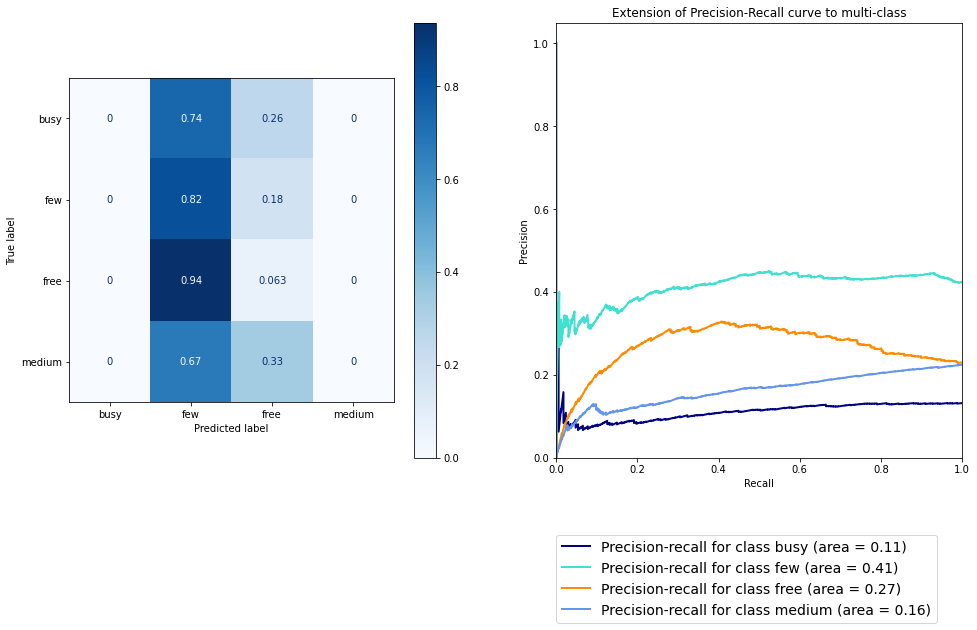

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.43      0.82      0.56       531
           2       0.07      0.06      0.07       287
           3       0.00      0.00      0.00       285

    accuracy                           0.36      1270
   macro avg       0.12      0.22      0.16      1270
weighted avg       0.20      0.36      0.25      1270

training samples from video:  100
accuracy: 0.4086614173228346
[[0.         0.94011976 0.05988024 0.        ]
 [0.         0.93596987 0.06403013 0.        ]
 [0.         0.92334495 0.07665505 0.        ]
 [0.         0.94385965 0.05614035 0.        ]]


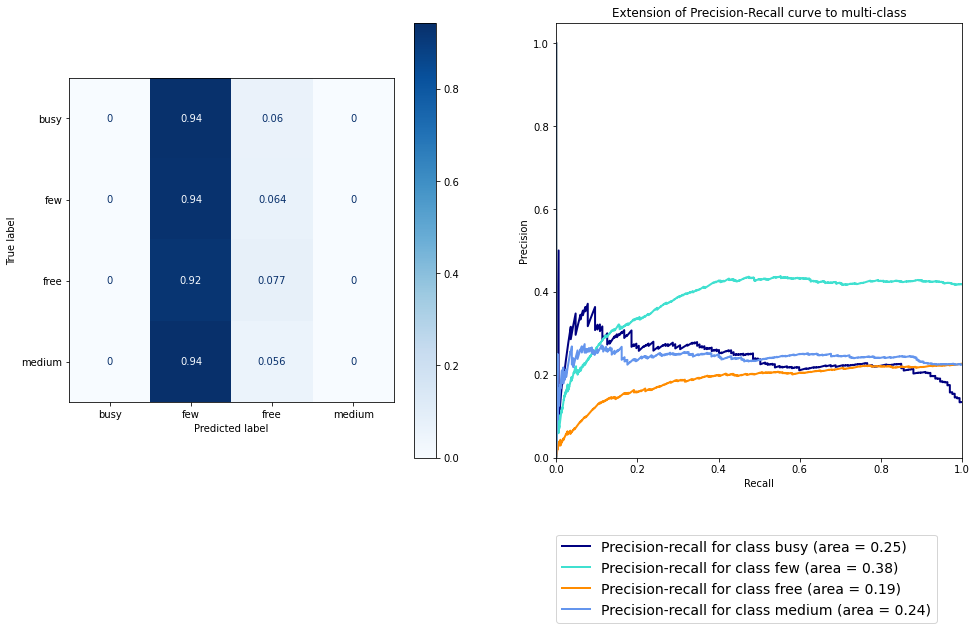

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      0.94      0.58       531
           2       0.27      0.08      0.12       287
           3       0.00      0.00      0.00       285

    accuracy                           0.41      1270
   macro avg       0.17      0.25      0.17      1270
weighted avg       0.24      0.41      0.27      1270

training samples from video:  200
accuracy: 0.4440944881889764
[[0.04790419 0.92814371 0.0239521  0.        ]
 [0.01506591 0.78531073 0.19962335 0.        ]
 [0.00348432 0.51219512 0.48432056 0.        ]
 [0.01754386 0.86315789 0.11929825 0.        ]]


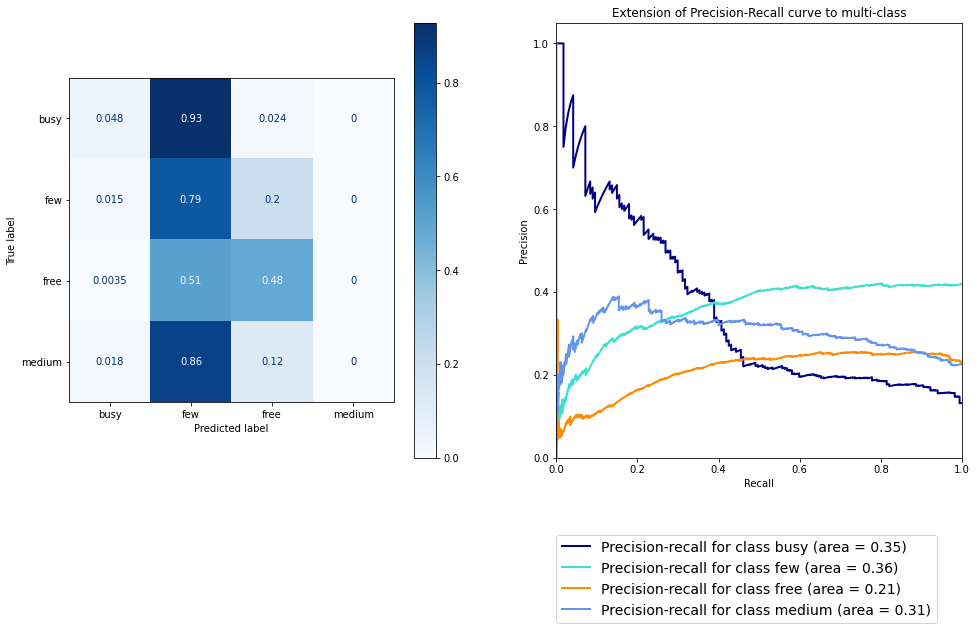

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.36      0.05      0.08       167
           1       0.43      0.79      0.56       531
           2       0.49      0.48      0.49       287
           3       0.00      0.00      0.00       285

    accuracy                           0.44      1270
   macro avg       0.32      0.33      0.28      1270
weighted avg       0.34      0.44      0.35      1270

training samples from video:  500
accuracy: 0.4590551181102362
[[0.         0.98203593 0.01796407 0.        ]
 [0.         0.86629002 0.13370998 0.        ]
 [0.         0.57142857 0.42857143 0.        ]
 [0.         0.91578947 0.08421053 0.        ]]


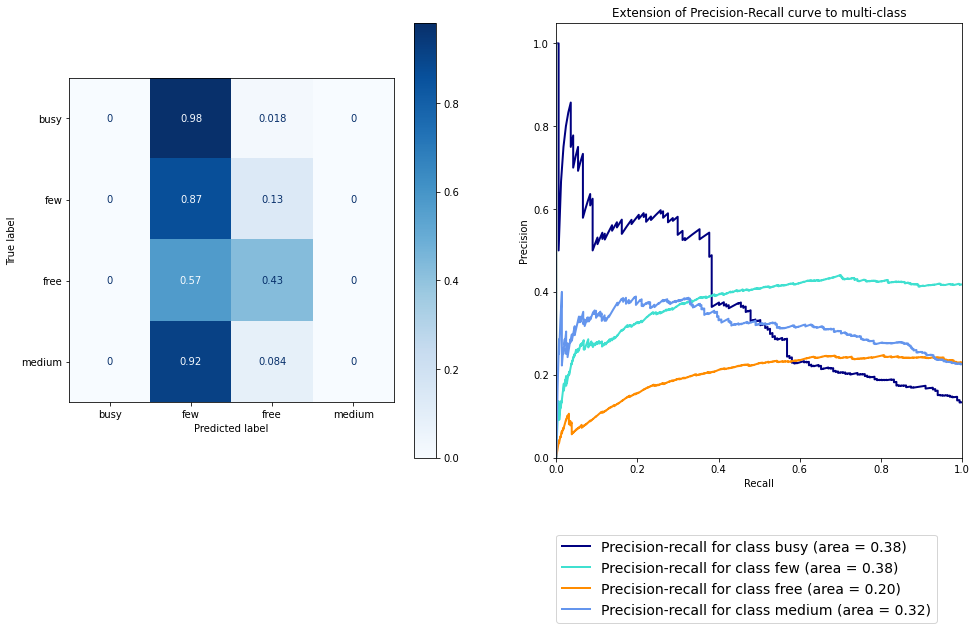

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.44      0.87      0.58       531
           2       0.56      0.43      0.48       287
           3       0.00      0.00      0.00       285

    accuracy                           0.46      1270
   macro avg       0.25      0.32      0.27      1270
weighted avg       0.31      0.46      0.35      1270

training samples from video:  1000
accuracy: 0.5
[[0.36526946 0.5988024  0.0239521  0.01197605]
 [0.0527307  0.76271186 0.18455744 0.        ]
 [0.03135889 0.38327526 0.58536585 0.        ]
 [0.07368421 0.83508772 0.0877193  0.00350877]]


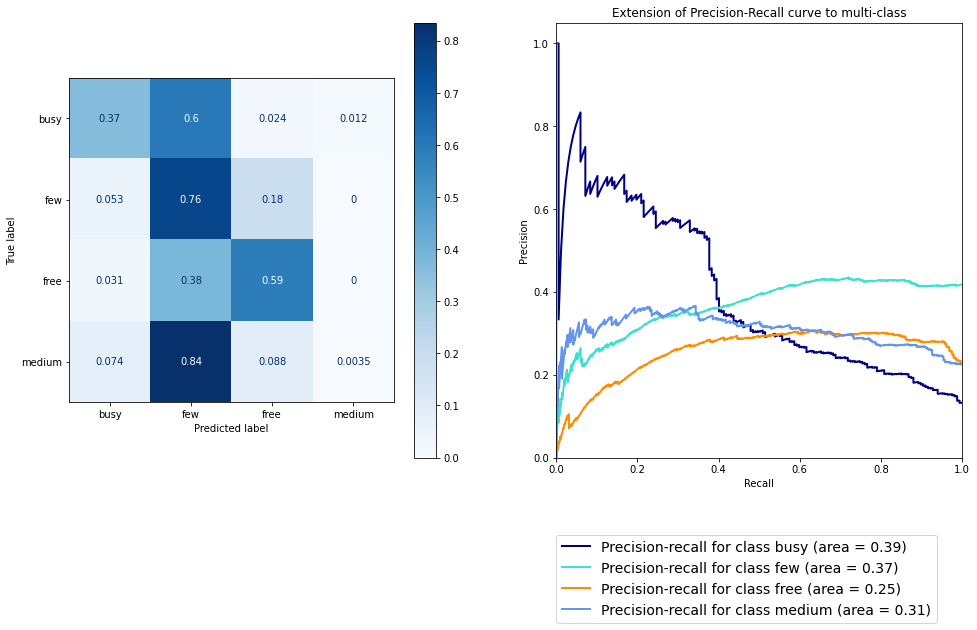

              precision    recall  f1-score   support

           0       0.51      0.37      0.43       167
           1       0.47      0.76      0.59       531
           2       0.57      0.59      0.58       287
           3       0.33      0.00      0.01       285

    accuracy                           0.50      1270
   macro avg       0.47      0.43      0.40      1270
weighted avg       0.47      0.50      0.43      1270

training samples from video:  1500
accuracy: 0.49606299212598426
[[0.35928144 0.55688623 0.01796407 0.06586826]
 [0.0527307  0.78907721 0.14500942 0.01318267]
 [0.03135889 0.45993031 0.50174216 0.00696864]
 [0.07368421 0.84912281 0.05263158 0.0245614 ]]


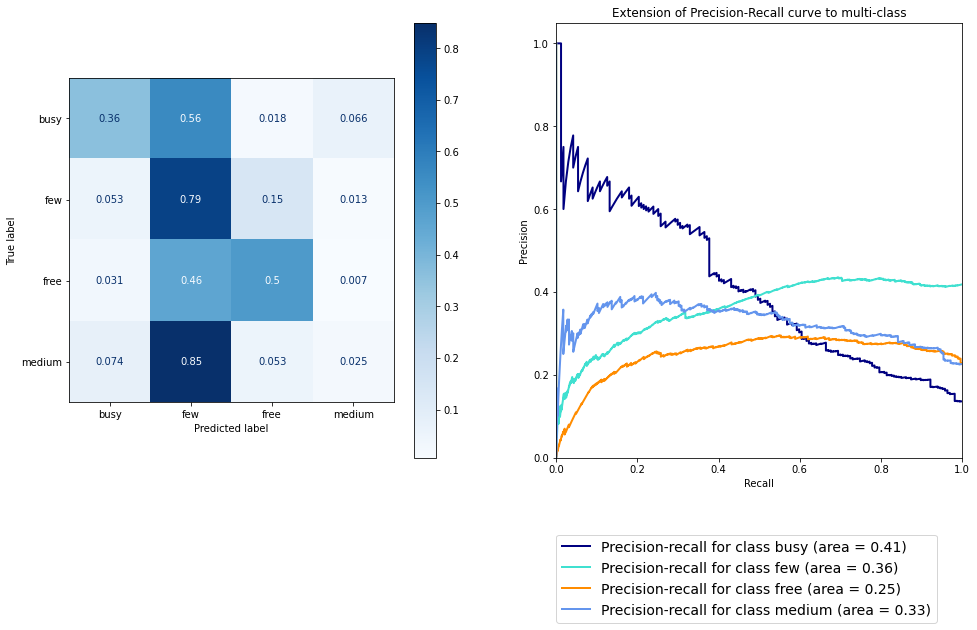

              precision    recall  f1-score   support

           0       0.51      0.36      0.42       167
           1       0.47      0.79      0.59       531
           2       0.60      0.50      0.55       287
           3       0.26      0.02      0.04       285

    accuracy                           0.50      1270
   macro avg       0.46      0.42      0.40      1270
weighted avg       0.46      0.50      0.44      1270

training samples from video:  2000
accuracy: 0.5023622047244094
[[0.35928144 0.44311377 0.01796407 0.17964072]
 [0.0527307  0.74199623 0.15065913 0.05461394]
 [0.03135889 0.43205575 0.51916376 0.0174216 ]
 [0.07368421 0.75087719 0.05263158 0.12280702]]


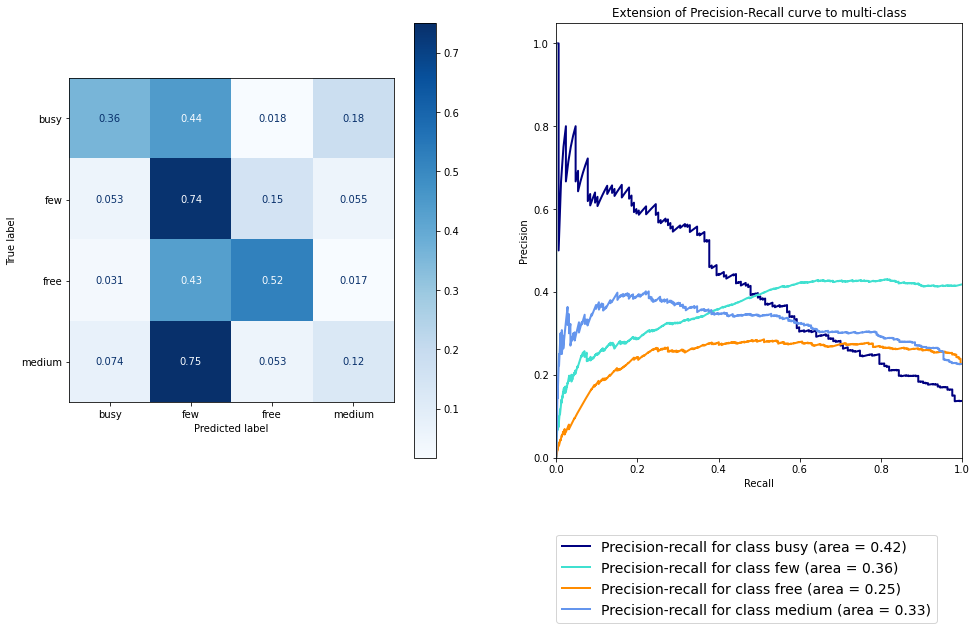

              precision    recall  f1-score   support

           0       0.51      0.36      0.42       167
           1       0.49      0.74      0.59       531
           2       0.60      0.52      0.56       287
           3       0.35      0.12      0.18       285

    accuracy                           0.50      1270
   macro avg       0.49      0.44      0.44      1270
weighted avg       0.49      0.50      0.47      1270

training samples from video:  3000
accuracy: 0.511023622047244
[[0.36526946 0.45508982 0.01796407 0.16167665]
 [0.0527307  0.74576271 0.15065913 0.05084746]
 [0.03135889 0.3902439  0.56097561 0.0174216 ]
 [0.07368421 0.75789474 0.05964912 0.10877193]]


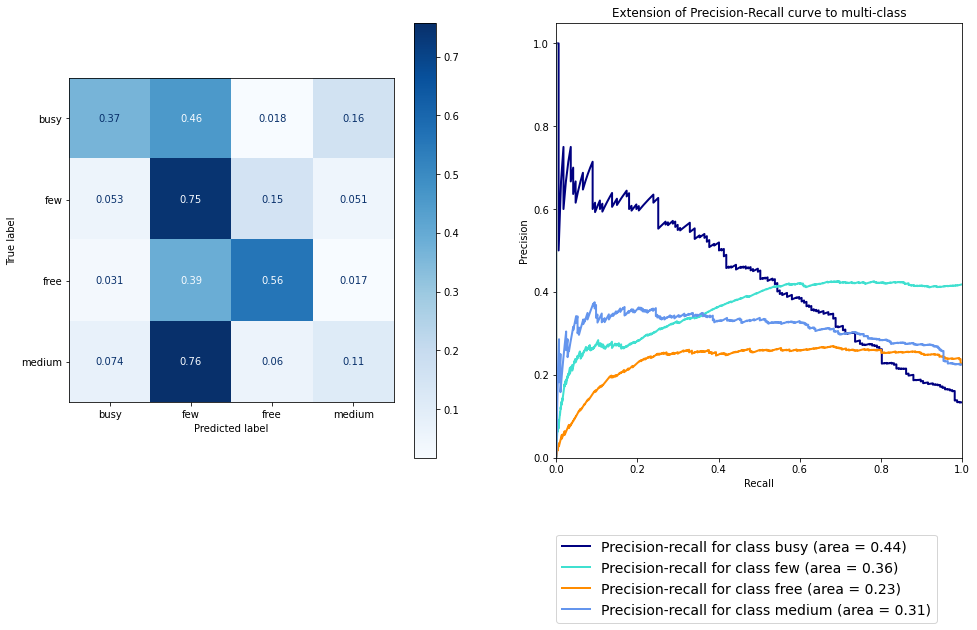

              precision    recall  f1-score   support

           0       0.51      0.37      0.43       167
           1       0.49      0.75      0.60       531
           2       0.62      0.56      0.59       287
           3       0.34      0.11      0.17       285

    accuracy                           0.51      1270
   macro avg       0.49      0.45      0.44      1270
weighted avg       0.49      0.51      0.47      1270

training samples from video:  4000
accuracy: 0.5165354330708661
[[0.36526946 0.46706587 0.01796407 0.1497006 ]
 [0.0527307  0.75141243 0.15442561 0.04143126]
 [0.03135889 0.36933798 0.58536585 0.01393728]
 [0.07368421 0.76491228 0.06315789 0.09824561]]


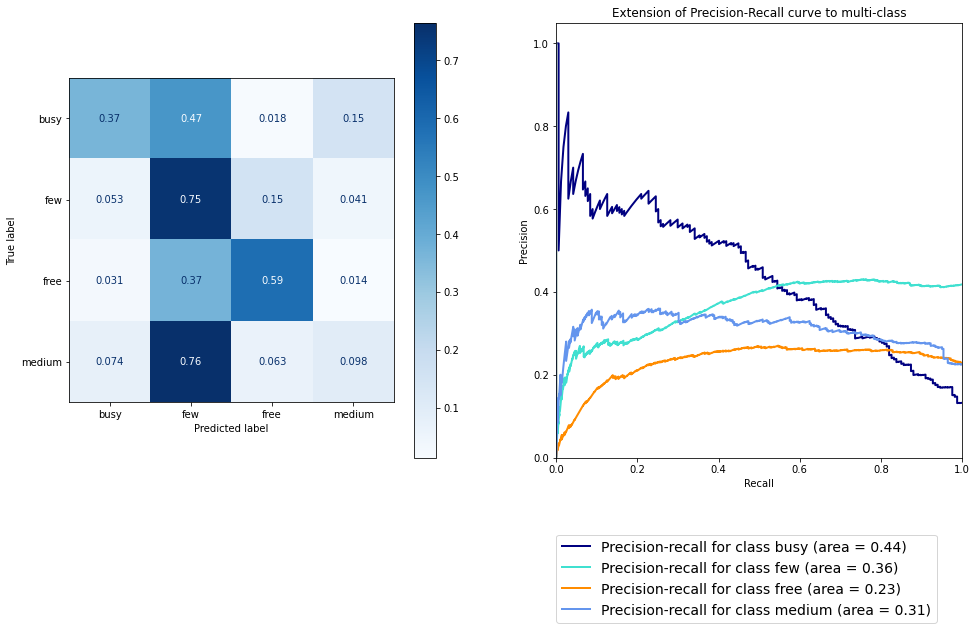

              precision    recall  f1-score   support

           0       0.51      0.37      0.43       167
           1       0.50      0.75      0.60       531
           2       0.62      0.59      0.60       287
           3       0.35      0.10      0.15       285

    accuracy                           0.52      1270
   macro avg       0.50      0.45      0.45      1270
weighted avg       0.50      0.52      0.48      1270

training samples from video:  5076
accuracy: 0.5141732283464567
[[0.36526946 0.4011976  0.01796407 0.21556886]
 [0.0527307  0.69114878 0.15065913 0.10546139]
 [0.02787456 0.3554007  0.57142857 0.04529617]
 [0.07368421 0.64561404 0.06666667 0.21403509]]


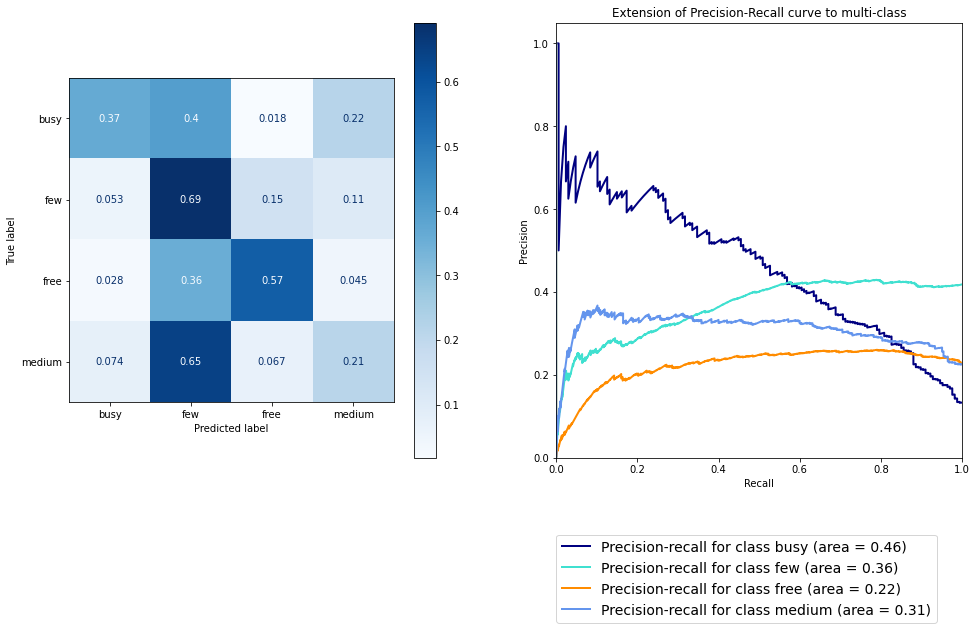

              precision    recall  f1-score   support

           0       0.52      0.37      0.43       167
           1       0.51      0.69      0.59       531
           2       0.62      0.57      0.59       287
           3       0.37      0.21      0.27       285

    accuracy                           0.51      1270
   macro avg       0.50      0.46      0.47      1270
weighted avg       0.50      0.51      0.50      1270



In [46]:
from sklearn.svm import SVC

acc = {}
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

for num in numOfSamples:
    print("training samples from video: ", num)
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], features2), axis=0)
        y_combine_train = np.concatenate((y_train[:num],labels["total_encoder"]), axis=0)
    else:
        X_combine_train = features2
        y_combine_train = labels["total_encoder"]

    clf = SVC(kernel="linear", decision_function_shape="ovo", random_state=42)
    clf.fit(X_combine_train, y_combine_train)
    random_accuracy = evaluate_svm(clf, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy

In [47]:
print(acc)

{0: 0.35748031496062993, 100: 0.4086614173228346, 200: 0.4440944881889764, 500: 0.4590551181102362, 1000: 0.5, 1500: 0.49606299212598426, 2000: 0.5023622047244094, 3000: 0.511023622047244, 4000: 0.5165354330708661, 5076: 0.5141732283464567}


### Random forest

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report

def evaluate(model, test_features, test_labels, labels):
    accuracy = model.score(test_features, test_labels)
    print("accuracy:", accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, test_features, test_labels,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.predict_proba(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()
    
    print(classification_report(test_labels, model.predict(test_features)))
    
    return accuracy



In [13]:
X_train.shape

(5076, 128)

In [14]:
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

In [15]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_split = [2, 5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.0min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.41811023622047244
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


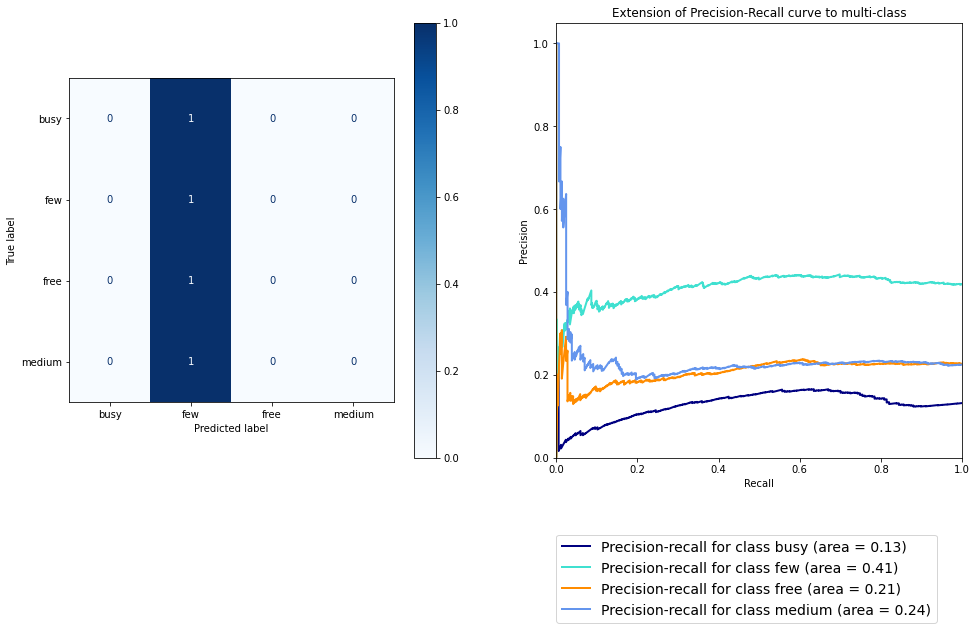

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      1.00      0.59       531
           2       0.00      0.00      0.00       287
           3       0.00      0.00      0.00       285

    accuracy                           0.42      1270
   macro avg       0.10      0.25      0.15      1270
weighted avg       0.17      0.42      0.25      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.1min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 50}
accuracy: 0.4779527559055118
[[0.17365269 0.49101796 0.04191617 0.29341317]
 [0.02259887 0.69868173 0.18832392 0.09039548]
 [0.00348432 0.40069686 0.55052265 0.04529617]
 [0.04210526 0.66315789 0.12280702 0.17192982]]


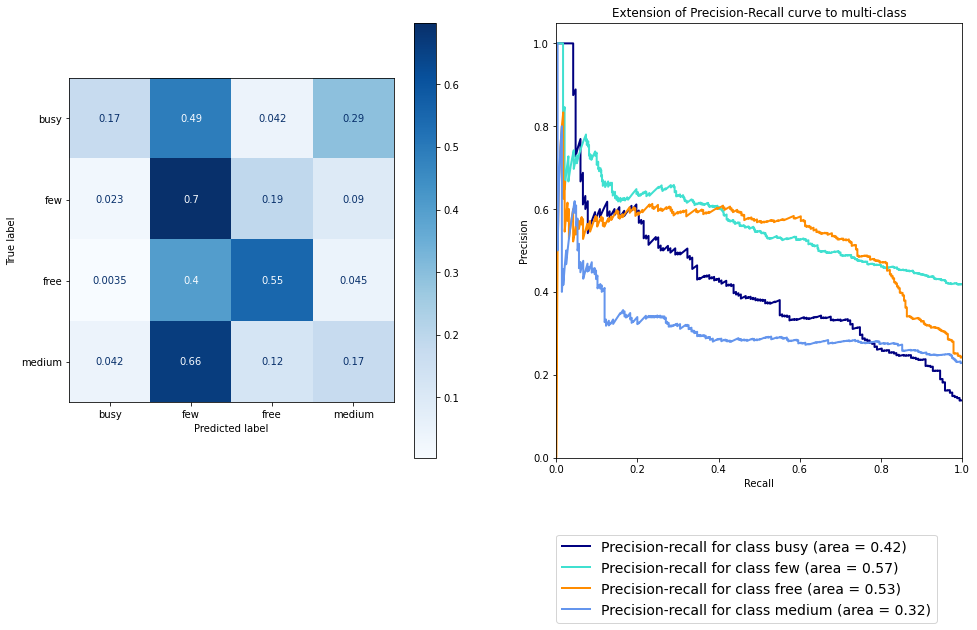

              precision    recall  f1-score   support

           0       0.54      0.17      0.26       167
           1       0.49      0.70      0.58       531
           2       0.53      0.55      0.54       287
           3       0.31      0.17      0.22       285

    accuracy                           0.48      1270
   macro avg       0.47      0.40      0.40      1270
weighted avg       0.46      0.48      0.45      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.3min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.4881889763779528
[[0.13173653 0.71856287 0.03592814 0.11377246]
 [0.00753296 0.80225989 0.14312618 0.04708098]
 [0.00696864 0.54006969 0.45296167 0.        ]
 [0.02105263 0.77192982 0.05964912 0.14736842]]


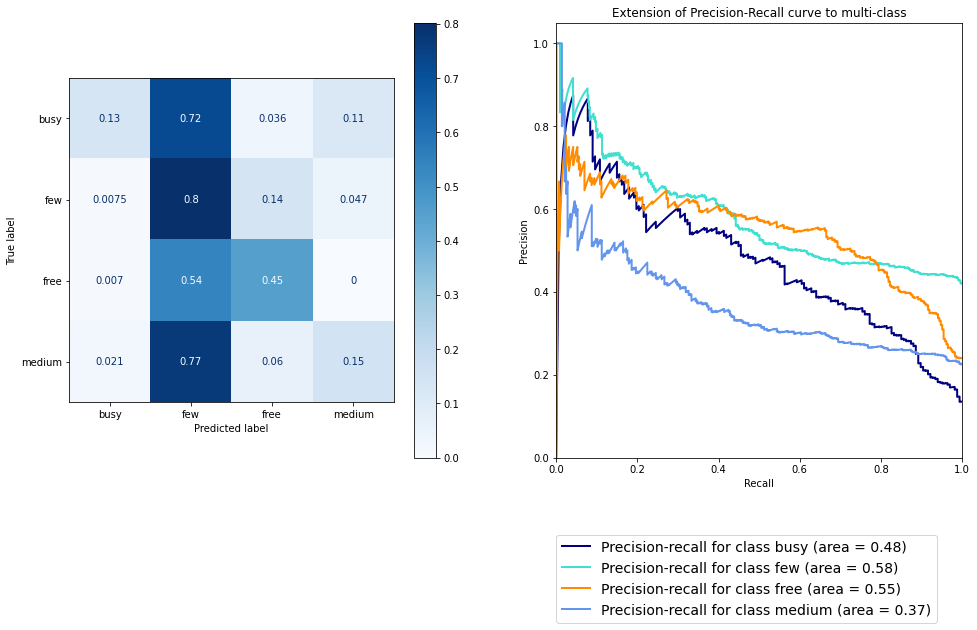

              precision    recall  f1-score   support

           0       0.65      0.13      0.22       167
           1       0.46      0.80      0.59       531
           2       0.57      0.45      0.50       287
           3       0.49      0.15      0.23       285

    accuracy                           0.49      1270
   macro avg       0.54      0.38      0.38      1270
weighted avg       0.52      0.49      0.44      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.7min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.5346456692913386
[[0.31736527 0.40718563 0.04191617 0.23353293]
 [0.02259887 0.69491525 0.16195857 0.12052731]
 [0.01045296 0.35191638 0.60627178 0.03135889]
 [0.05614035 0.57894737 0.07368421 0.29122807]]


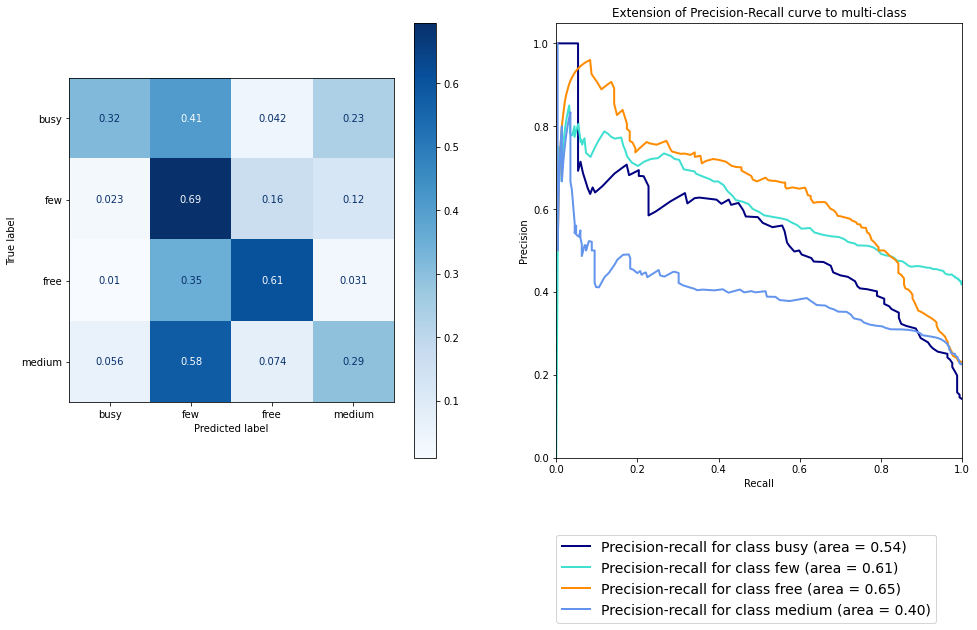

              precision    recall  f1-score   support

           0       0.63      0.32      0.42       167
           1       0.52      0.69      0.60       531
           2       0.60      0.61      0.61       287
           3       0.43      0.29      0.35       285

    accuracy                           0.53      1270
   macro avg       0.55      0.48      0.49      1270
weighted avg       0.53      0.53      0.52      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.4min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 50}
accuracy: 0.5913385826771653
[[0.41916168 0.25748503 0.0239521  0.2994012 ]
 [0.03766478 0.69303202 0.14124294 0.12806026]
 [0.02787456 0.271777   0.65156794 0.04878049]
 [0.06666667 0.44561404 0.04561404 0.44210526]]


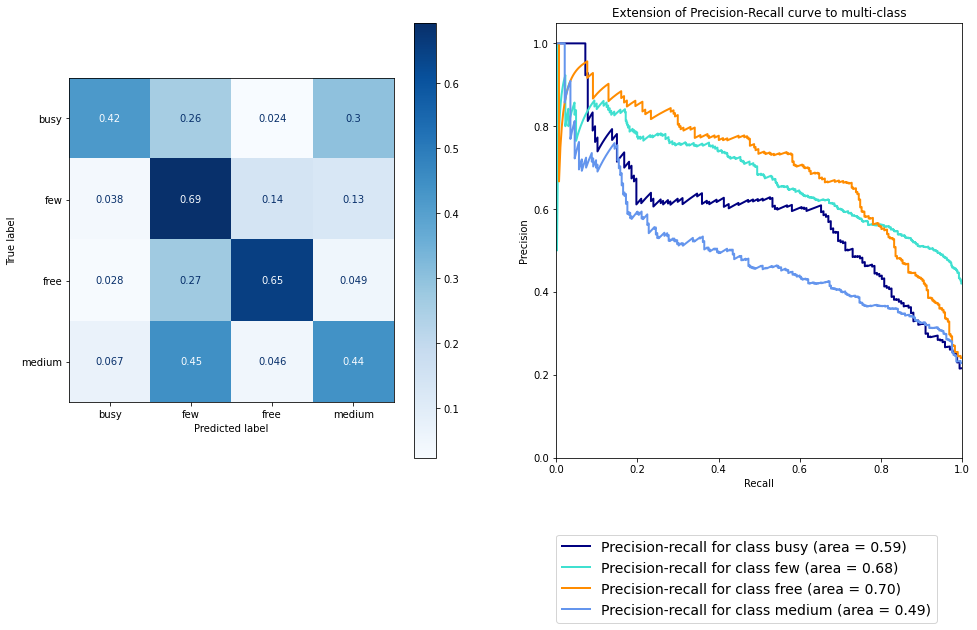

              precision    recall  f1-score   support

           0       0.60      0.42      0.49       167
           1       0.60      0.69      0.64       531
           2       0.67      0.65      0.66       287
           3       0.49      0.44      0.46       285

    accuracy                           0.59      1270
   macro avg       0.59      0.55      0.56      1270
weighted avg       0.59      0.59      0.59      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.2min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.6251968503937008
[[0.53293413 0.21556886 0.00598802 0.24550898]
 [0.03201507 0.73446328 0.11111111 0.12241055]
 [0.02787456 0.2543554  0.67944251 0.03832753]
 [0.09122807 0.46315789 0.0245614  0.42105263]]


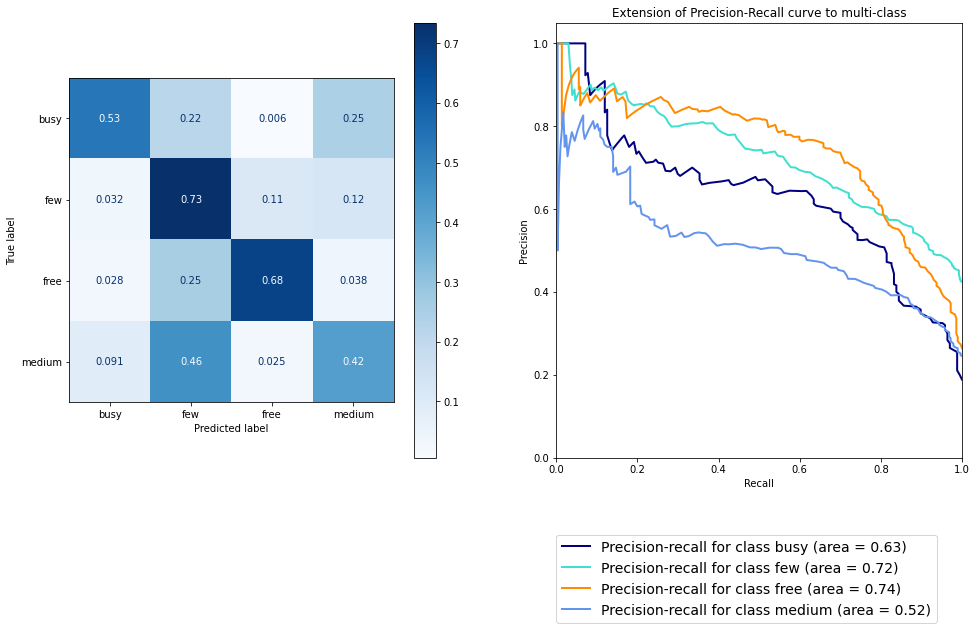

              precision    recall  f1-score   support

           0       0.64      0.53      0.58       167
           1       0.62      0.73      0.67       531
           2       0.74      0.68      0.71       287
           3       0.51      0.42      0.46       285

    accuracy                           0.63      1270
   macro avg       0.63      0.59      0.61      1270
weighted avg       0.62      0.63      0.62      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.0min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.6228346456692914
[[0.53892216 0.16167665 0.01197605 0.28742515]
 [0.03766478 0.70056497 0.13559322 0.12617702]
 [0.02439024 0.2369338  0.69686411 0.04181185]
 [0.09122807 0.42105263 0.03508772 0.45263158]]


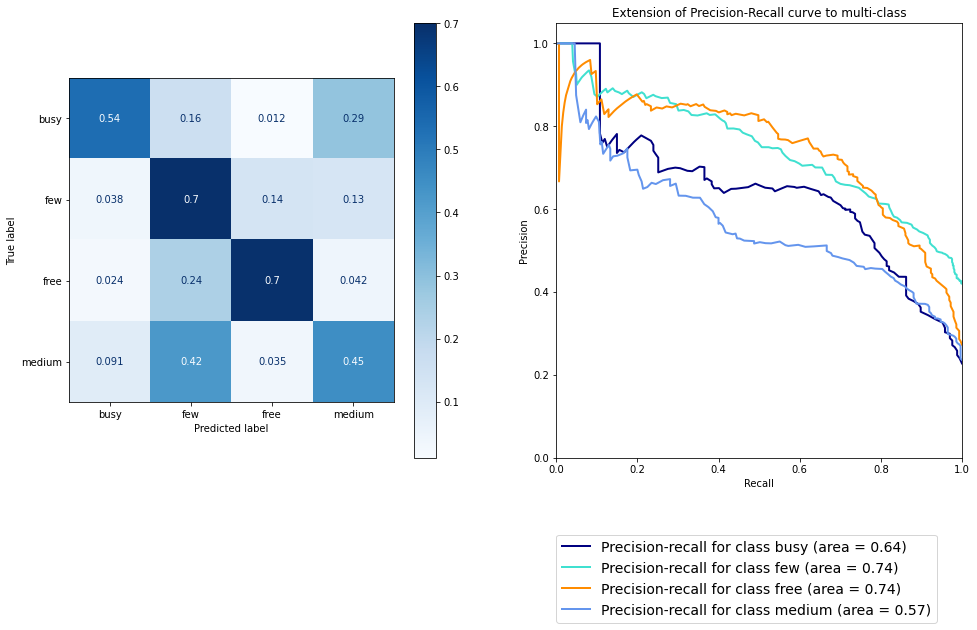

              precision    recall  f1-score   support

           0       0.63      0.54      0.58       167
           1       0.63      0.70      0.67       531
           2       0.70      0.70      0.70       287
           3       0.50      0.45      0.48       285

    accuracy                           0.62      1270
   macro avg       0.62      0.60      0.61      1270
weighted avg       0.62      0.62      0.62      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.6min finished


{'n_estimators': 294, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 80}
accuracy: 0.6433070866141732
[[0.54491018 0.21556886 0.0239521  0.21556886]
 [0.03389831 0.74199623 0.12806026 0.0960452 ]
 [0.02090592 0.2195122  0.73170732 0.02787456]
 [0.09122807 0.45964912 0.02105263 0.42807018]]


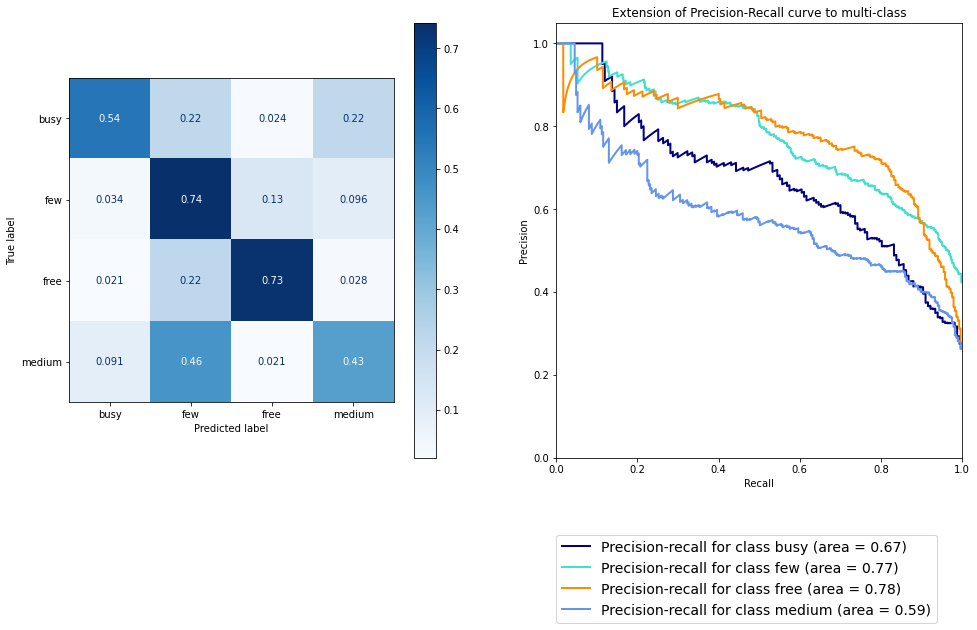

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       167
           1       0.63      0.74      0.68       531
           2       0.73      0.73      0.73       287
           3       0.56      0.43      0.49       285

    accuracy                           0.64      1270
   macro avg       0.64      0.61      0.62      1270
weighted avg       0.64      0.64      0.64      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.1min finished


{'n_estimators': 1715, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 90}
accuracy: 0.6834645669291338
[[0.60479042 0.13772455 0.01796407 0.23952096]
 [0.03201507 0.77024482 0.11864407 0.07909605]
 [0.02090592 0.16724739 0.7804878  0.03135889]
 [0.09122807 0.4245614  0.01403509 0.47017544]]


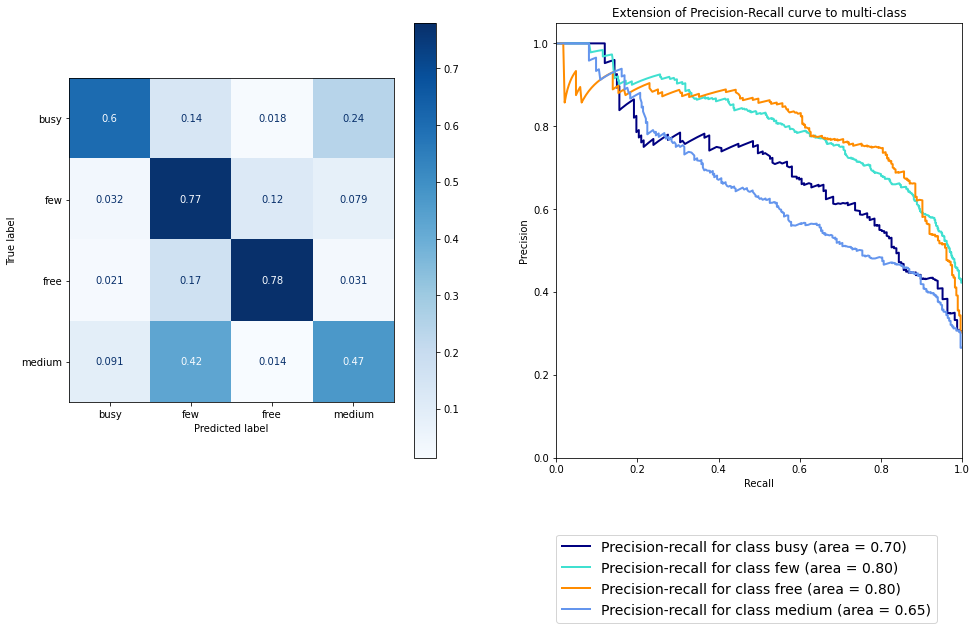

              precision    recall  f1-score   support

           0       0.67      0.60      0.64       167
           1       0.68      0.77      0.72       531
           2       0.76      0.78      0.77       287
           3       0.60      0.47      0.53       285

    accuracy                           0.68      1270
   macro avg       0.68      0.66      0.66      1270
weighted avg       0.68      0.68      0.68      1270

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.8min finished


{'n_estimators': 1147, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 70}
accuracy: 0.7
[[0.64670659 0.13772455 0.00598802 0.20958084]
 [0.03013183 0.77024482 0.11864407 0.08097928]
 [0.01393728 0.18466899 0.77351916 0.02787456]
 [0.07719298 0.38245614 0.01403509 0.52631579]]


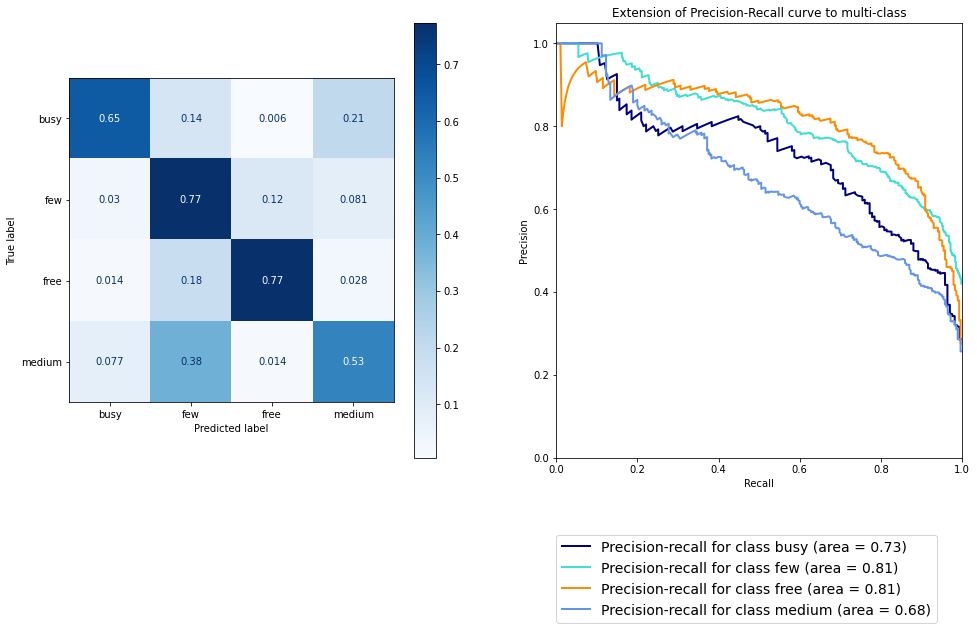

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       167
           1       0.69      0.77      0.73       531
           2       0.77      0.77      0.77       287
           3       0.64      0.53      0.58       285

    accuracy                           0.70      1270
   macro avg       0.70      0.68      0.69      1270
weighted avg       0.70      0.70      0.70      1270



In [17]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# acc_range = {}
# acc = {}

# for num in numOfSamples:
#     if num > 0:
#         X_combine_train = np.concatenate((X_train[:num, :], features2), axis=0)
#         y_combine_train = np.concatenate((y_train[:num],labels["total_encoder"]), axis=0)
#     else:
#         X_combine_train = features2
#         y_combine_train = labels["total_encoder"]

#     random_forest_clf = RandomForestClassifier(random_state=42)
#     rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#     rf_random.fit(X_combine_train, y_combine_train)
#     print(rf_random.best_params_)
#     best_random = rf_random.best_estimator_
#     random_accuracy = evaluate(best_random, X_test, y_test, labelencoder.classes_)
#     acc[num] = random_accuracy
#     acc_range[num] = rf_random.cv_results_

In [ ]:
print(acc_range)

In [ ]:
print(acc)

## Targat modality: audio

In [18]:
# Get 20% testing data from video
X_train, X_test, y_train, y_test = train_test_split(features2, labels["total_encoder"], test_size=0.2, random_state=42)

### SVM

training samples from audio:  0
accuracy: 0.3417322834645669
[[0.00598802 0.59281437 0.17964072 0.22155689]
 [0.01506591 0.69491525 0.20150659 0.08851224]
 [0.01045296 0.89198606 0.05574913 0.04181185]
 [0.00350877 0.56842105 0.25964912 0.16842105]]


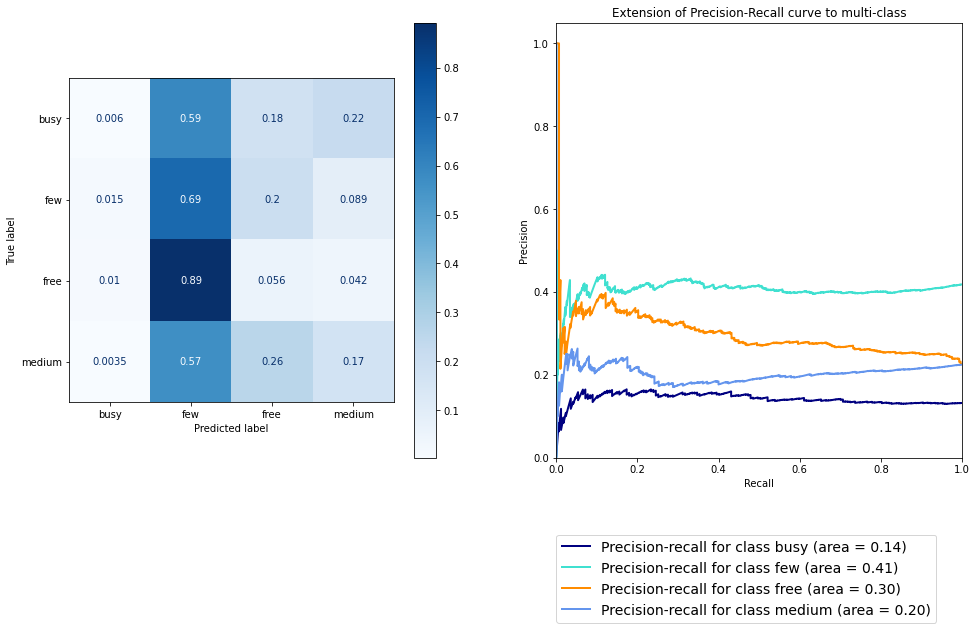

              precision    recall  f1-score   support

           0       0.08      0.01      0.01       167
           1       0.42      0.69      0.52       531
           2       0.07      0.06      0.06       287
           3       0.33      0.17      0.22       285

    accuracy                           0.34      1270
   macro avg       0.22      0.23      0.20      1270
weighted avg       0.27      0.34      0.28      1270

training samples from audio:  100
accuracy: 0.39763779527559057
[[0.03592814 0.56287425 0.05389222 0.34730539]
 [0.04519774 0.71751412 0.05084746 0.18644068]
 [0.02090592 0.7630662  0.1184669  0.09756098]
 [0.03157895 0.61403509 0.05964912 0.29473684]]


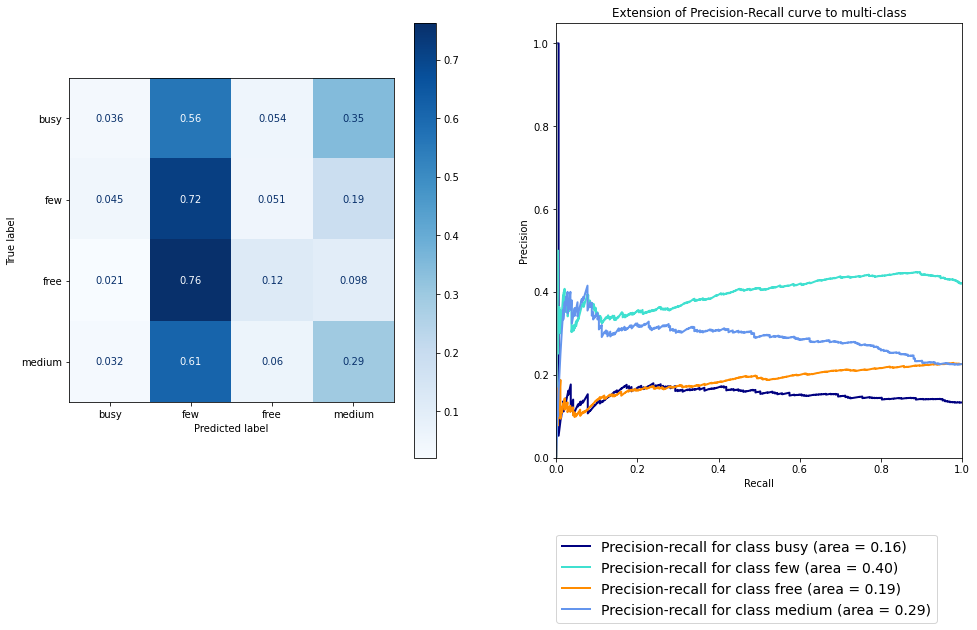

              precision    recall  f1-score   support

           0       0.13      0.04      0.06       167
           1       0.44      0.72      0.54       531
           2       0.39      0.12      0.18       287
           3       0.31      0.29      0.30       285

    accuracy                           0.40      1270
   macro avg       0.32      0.29      0.27      1270
weighted avg       0.36      0.40      0.34      1270

training samples from audio:  200
accuracy: 0.4259842519685039
[[0.         0.66467066 0.08383234 0.25149701]
 [0.         0.80602637 0.12241055 0.07156309]
 [0.00348432 0.71428571 0.25783972 0.02439024]
 [0.         0.78947368 0.07368421 0.13684211]]


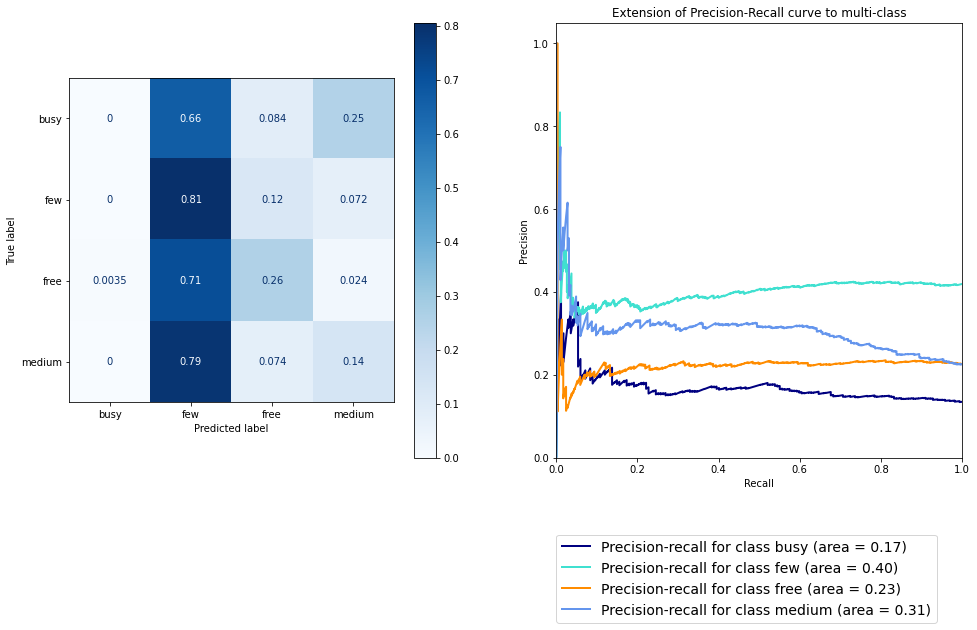

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.44      0.81      0.57       531
           2       0.43      0.26      0.32       287
           3       0.31      0.14      0.19       285

    accuracy                           0.43      1270
   macro avg       0.29      0.30      0.27      1270
weighted avg       0.35      0.43      0.35      1270

training samples from audio:  500
accuracy: 0.4692913385826772
[[0.         0.8502994  0.1257485  0.0239521 ]
 [0.         0.85499058 0.14312618 0.00188324]
 [0.         0.51567944 0.48432056 0.        ]
 [0.         0.89824561 0.09122807 0.01052632]]


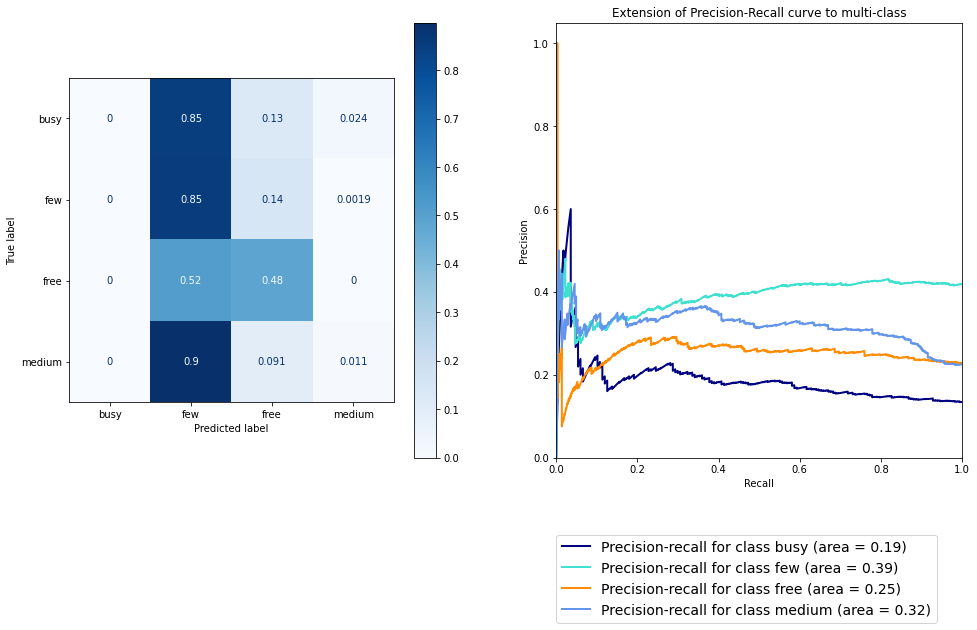

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.85      0.59       531
           2       0.53      0.48      0.51       287
           3       0.38      0.01      0.02       285

    accuracy                           0.47      1270
   macro avg       0.34      0.34      0.28      1270
weighted avg       0.39      0.47      0.37      1270

training samples from audio:  1000
accuracy: 0.4716535433070866
[[0.         0.85628743 0.1257485  0.01796407]
 [0.         0.85875706 0.14124294 0.        ]
 [0.         0.51916376 0.48083624 0.        ]
 [0.         0.89122807 0.09122807 0.01754386]]


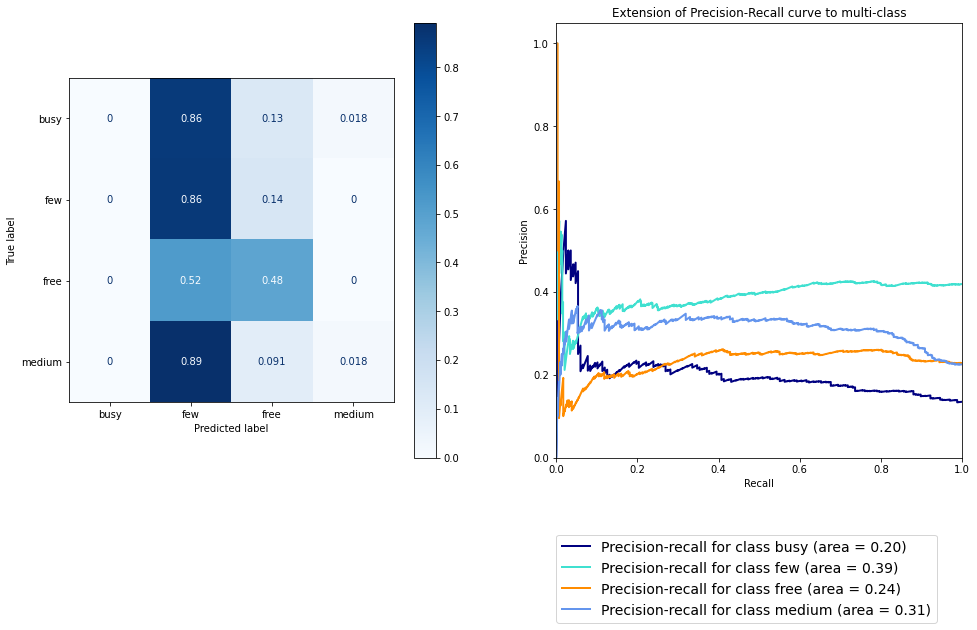

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.46      0.86      0.59       531
           2       0.53      0.48      0.50       287
           3       0.62      0.02      0.03       285

    accuracy                           0.47      1270
   macro avg       0.40      0.34      0.28      1270
weighted avg       0.45      0.47      0.37      1270

training samples from audio:  1500
accuracy: 0.462992125984252
[[0.         0.89221557 0.10778443 0.        ]
 [0.         0.86629002 0.13370998 0.        ]
 [0.         0.55400697 0.44599303 0.        ]
 [0.         0.90877193 0.09122807 0.        ]]


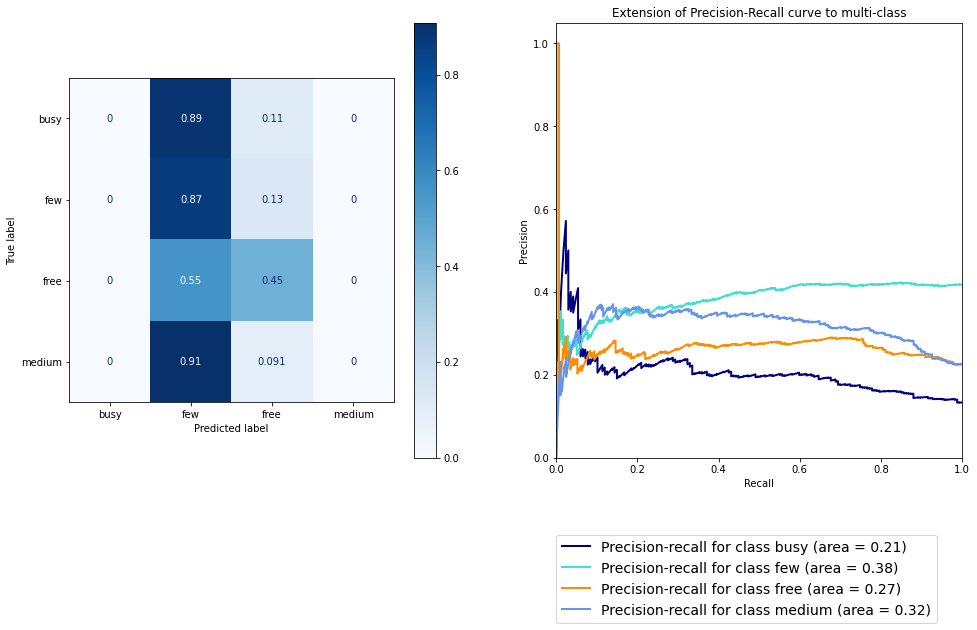

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.87      0.59       531
           2       0.53      0.45      0.48       287
           3       0.00      0.00      0.00       285

    accuracy                           0.46      1270
   macro avg       0.24      0.33      0.27      1270
weighted avg       0.31      0.46      0.36      1270

training samples from audio:  2000
accuracy: 0.46062992125984253
[[0.         0.85628743 0.14371257 0.        ]
 [0.         0.83804143 0.16195857 0.        ]
 [0.         0.51219512 0.48780488 0.        ]
 [0.         0.90175439 0.09824561 0.        ]]


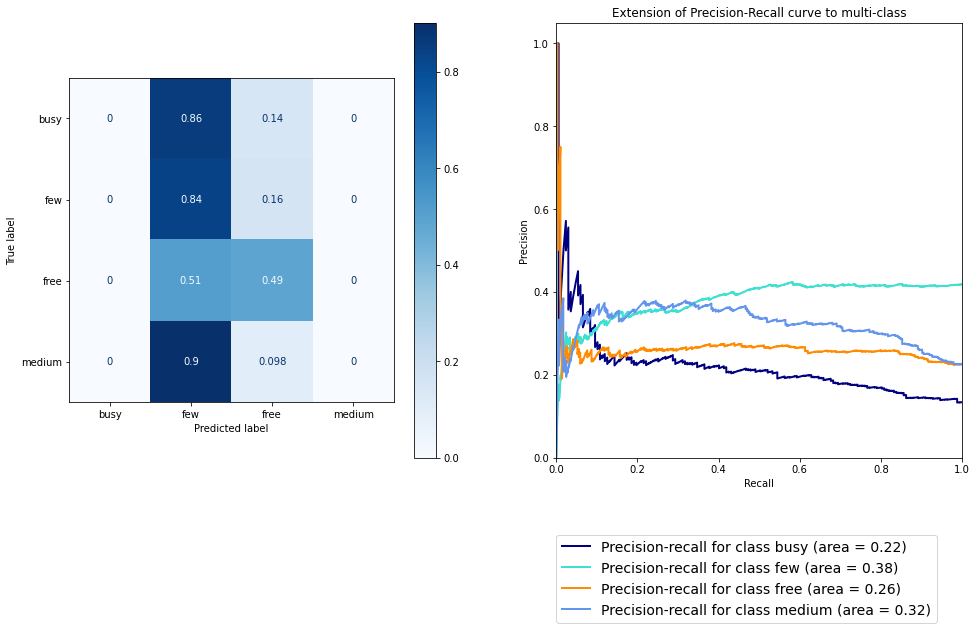

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.84      0.58       531
           2       0.50      0.49      0.50       287
           3       0.00      0.00      0.00       285

    accuracy                           0.46      1270
   macro avg       0.24      0.33      0.27      1270
weighted avg       0.30      0.46      0.36      1270

training samples from audio:  3000
accuracy: 0.4653543307086614
[[0.         0.83832335 0.16167665 0.        ]
 [0.         0.83239171 0.16760829 0.        ]
 [0.         0.48083624 0.51916376 0.        ]
 [0.         0.90175439 0.09824561 0.        ]]


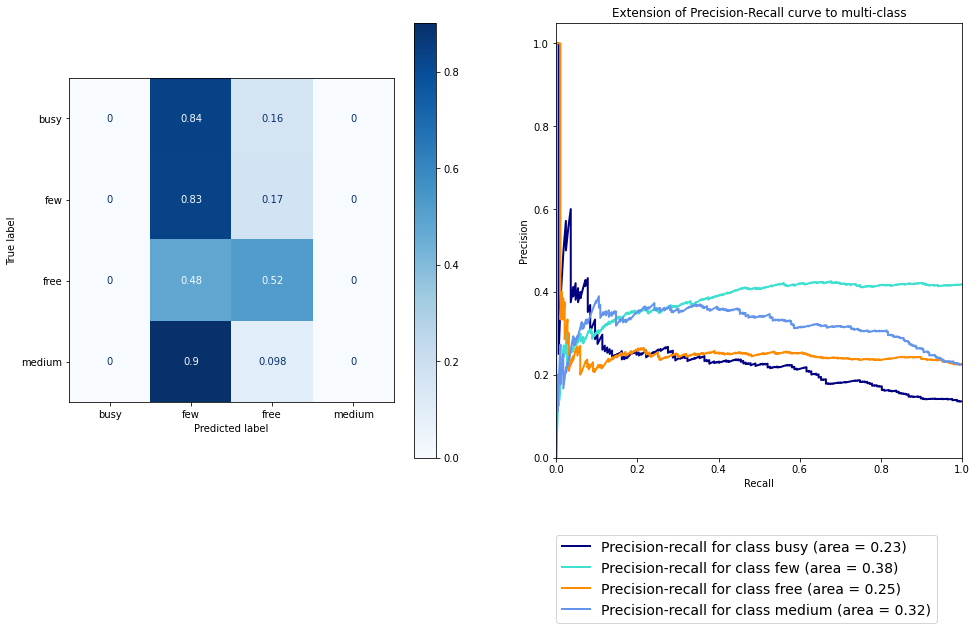

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.83      0.59       531
           2       0.51      0.52      0.51       287
           3       0.00      0.00      0.00       285

    accuracy                           0.47      1270
   macro avg       0.24      0.34      0.28      1270
weighted avg       0.30      0.47      0.36      1270

training samples from audio:  4000
accuracy: 0.46614173228346456
[[0.         0.8502994  0.1497006  0.        ]
 [0.         0.83615819 0.16384181 0.        ]
 [0.         0.48432056 0.51567944 0.        ]
 [0.         0.89122807 0.10877193 0.        ]]


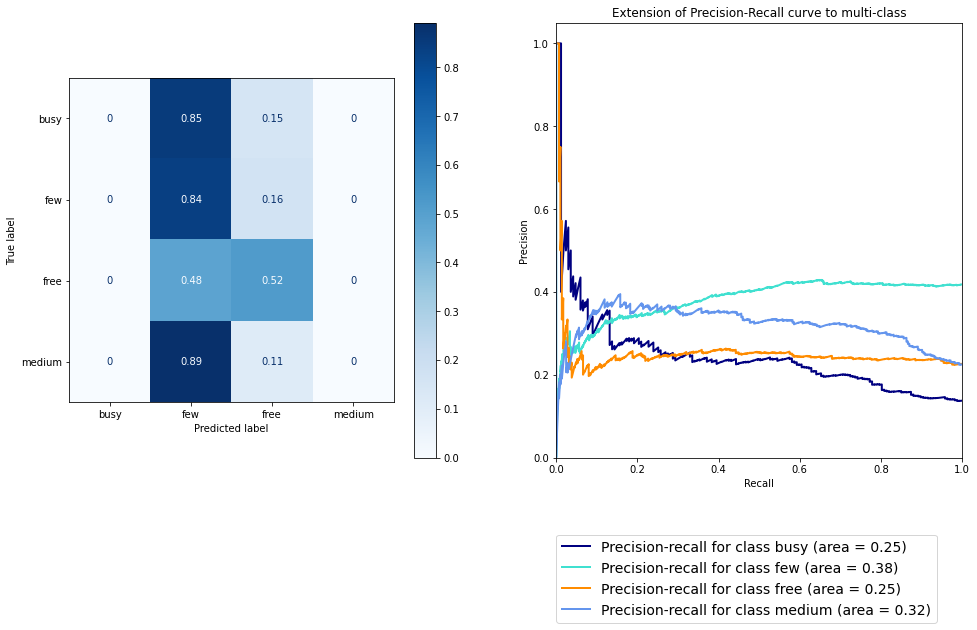

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.84      0.59       531
           2       0.51      0.52      0.51       287
           3       0.00      0.00      0.00       285

    accuracy                           0.47      1270
   macro avg       0.24      0.34      0.28      1270
weighted avg       0.30      0.47      0.36      1270

training samples from audio:  5076
accuracy: 0.4645669291338583
[[0.         0.86227545 0.13772455 0.        ]
 [0.         0.84557439 0.15442561 0.        ]
 [0.         0.5087108  0.4912892  0.        ]
 [0.         0.90175439 0.09824561 0.        ]]


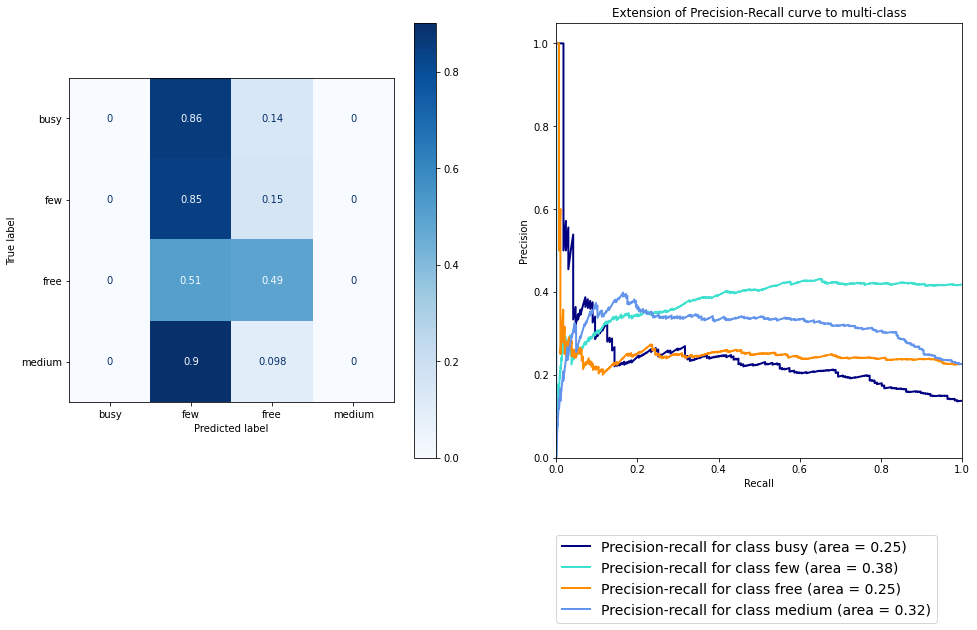

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.45      0.85      0.59       531
           2       0.51      0.49      0.50       287
           3       0.00      0.00      0.00       285

    accuracy                           0.46      1270
   macro avg       0.24      0.33      0.27      1270
weighted avg       0.30      0.46      0.36      1270



/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.svm import SVC


acc = {}
numOfSamples = [0, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5076]

for num in numOfSamples:
    print("training samples from audio: ", num)
    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], features1), axis=0)
        y_combine_train = np.concatenate((y_train[:num],labels["total_encoder"]), axis=0)
    else:
        X_combine_train = features1
        y_combine_train = labels["total_encoder"]

    clf = SVC(kernel="linear", decision_function_shape="ovo", random_state=42)
    clf.fit(X_combine_train, y_combine_train)
    random_accuracy = evaluate_svm(clf, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy

### Random Forest

training samples from audio:  0
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.5min finished


{'n_estimators': 1147, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 70}
accuracy: 0.41811023622047244
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


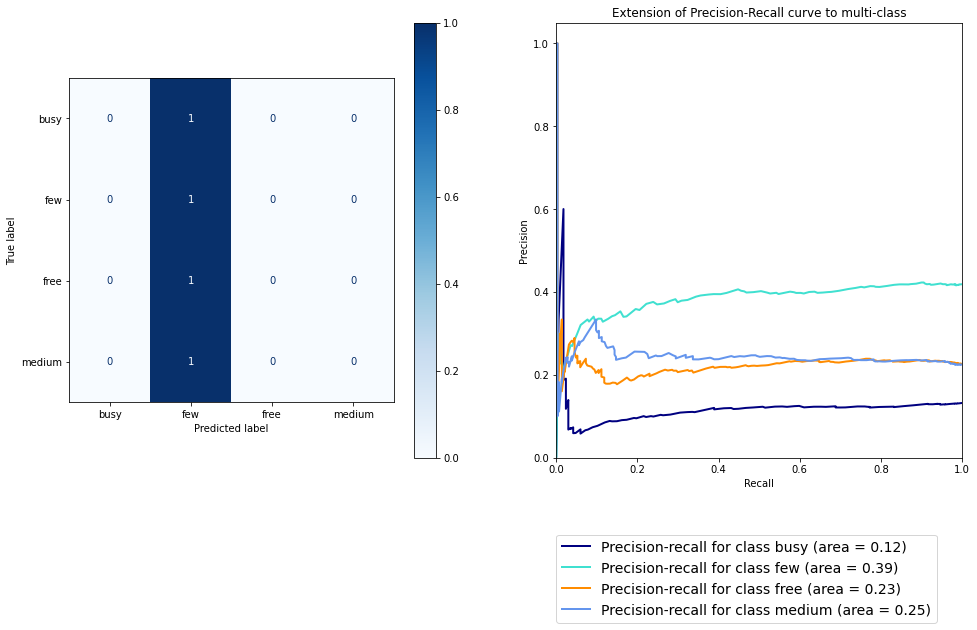

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.42      1.00      0.59       531
           2       0.00      0.00      0.00       287
           3       0.00      0.00      0.00       285

    accuracy                           0.42      1270
   macro avg       0.10      0.25      0.15      1270
weighted avg       0.17      0.42      0.25      1270

training samples from audio:  100
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished


{'n_estimators': 294, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 80}
accuracy: 0.4401574803149606
[[0.07185629 0.65868263 0.07185629 0.19760479]
 [0.02448211 0.76271186 0.07721281 0.13559322]
 [0.00348432 0.63066202 0.30662021 0.05923345]
 [0.04912281 0.70526316 0.05614035 0.18947368]]


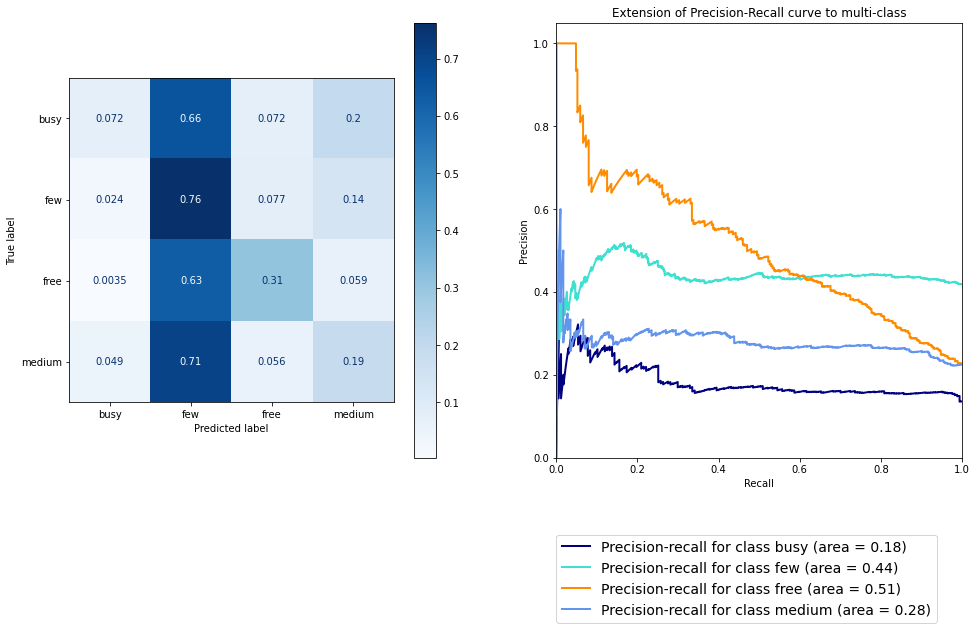

              precision    recall  f1-score   support

           0       0.30      0.07      0.12       167
           1       0.45      0.76      0.57       531
           2       0.56      0.31      0.40       287
           3       0.31      0.19      0.23       285

    accuracy                           0.44      1270
   macro avg       0.40      0.33      0.33      1270
weighted avg       0.42      0.44      0.39      1270

training samples from audio:  200
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.7min finished


{'n_estimators': 294, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 80}
accuracy: 0.4377952755905512
[[0.01197605 0.68862275 0.07185629 0.22754491]
 [0.01506591 0.76647834 0.12052731 0.09792844]
 [0.00696864 0.57142857 0.35888502 0.06271777]
 [0.01403509 0.78596491 0.04561404 0.15438596]]


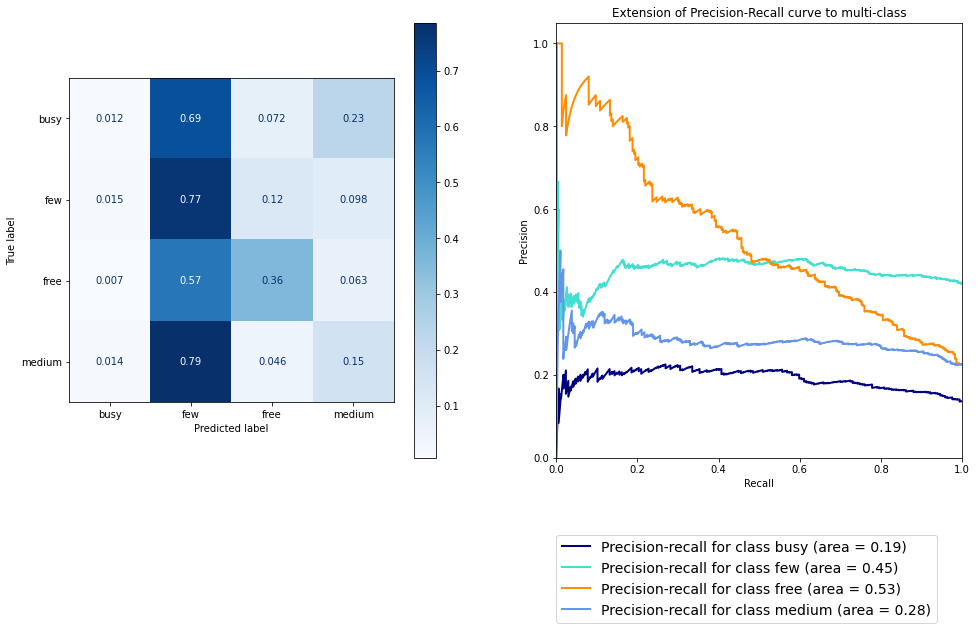

              precision    recall  f1-score   support

           0       0.12      0.01      0.02       167
           1       0.45      0.77      0.56       531
           2       0.54      0.36      0.43       287
           3       0.29      0.15      0.20       285

    accuracy                           0.44      1270
   macro avg       0.35      0.32      0.30      1270
weighted avg       0.39      0.44      0.38      1270

training samples from audio:  500
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.1min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.4763779527559055
[[0.         0.85628743 0.07784431 0.06586826]
 [0.         0.90018832 0.07344633 0.02636535]
 [0.         0.60278746 0.3902439  0.00696864]
 [0.         0.87719298 0.07017544 0.05263158]]


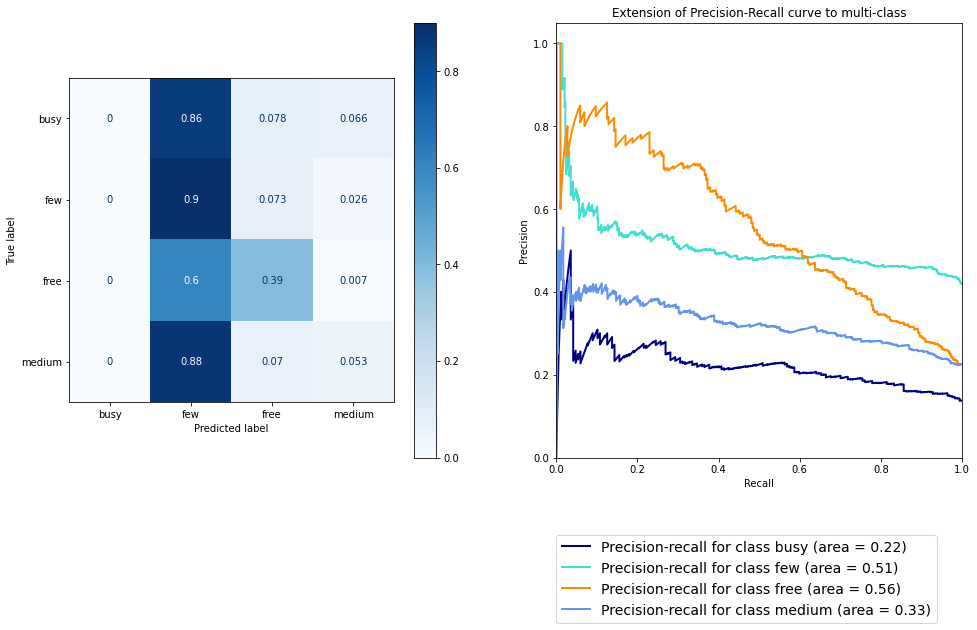

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.46      0.90      0.61       531
           2       0.61      0.39      0.48       287
           3       0.36      0.05      0.09       285

    accuracy                           0.48      1270
   macro avg       0.36      0.34      0.29      1270
weighted avg       0.41      0.48      0.38      1270

training samples from audio:  1000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.8min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.4874015748031496
[[0.         0.79041916 0.09580838 0.11377246]
 [0.         0.88323917 0.07344633 0.0433145 ]
 [0.         0.54006969 0.44947735 0.01045296]
 [0.00350877 0.86315789 0.05964912 0.07368421]]


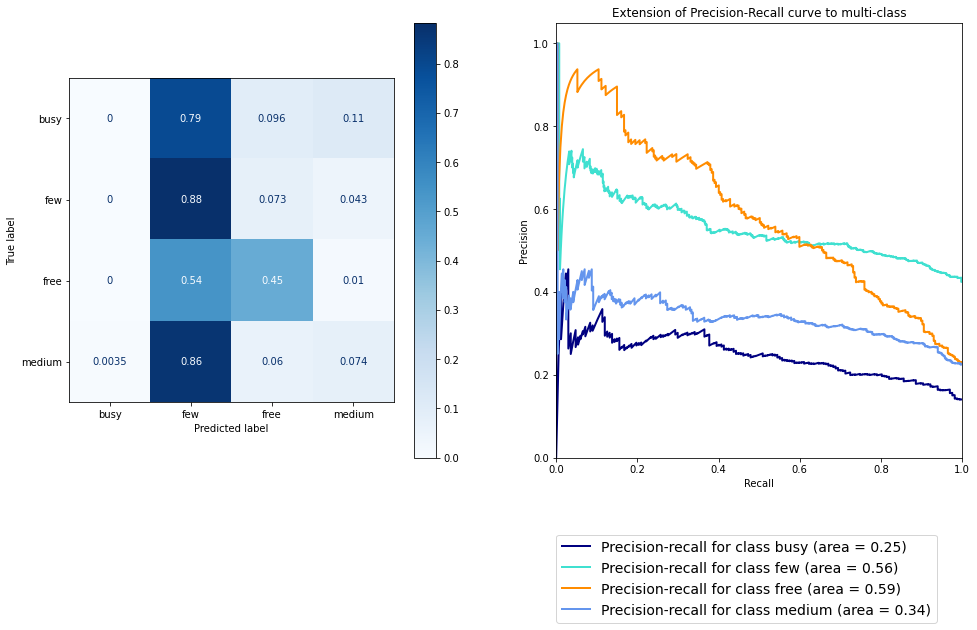

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.47      0.88      0.61       531
           2       0.64      0.45      0.53       287
           3       0.32      0.07      0.12       285

    accuracy                           0.49      1270
   macro avg       0.36      0.35      0.32      1270
weighted avg       0.41      0.49      0.40      1270

training samples from audio:  1500
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


{'n_estimators': 768, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.49291338582677163
[[0.         0.83233533 0.08383234 0.08383234]
 [0.00188324 0.89265537 0.07156309 0.03389831]
 [0.         0.54703833 0.45296167 0.        ]
 [0.         0.85614035 0.06666667 0.07719298]]


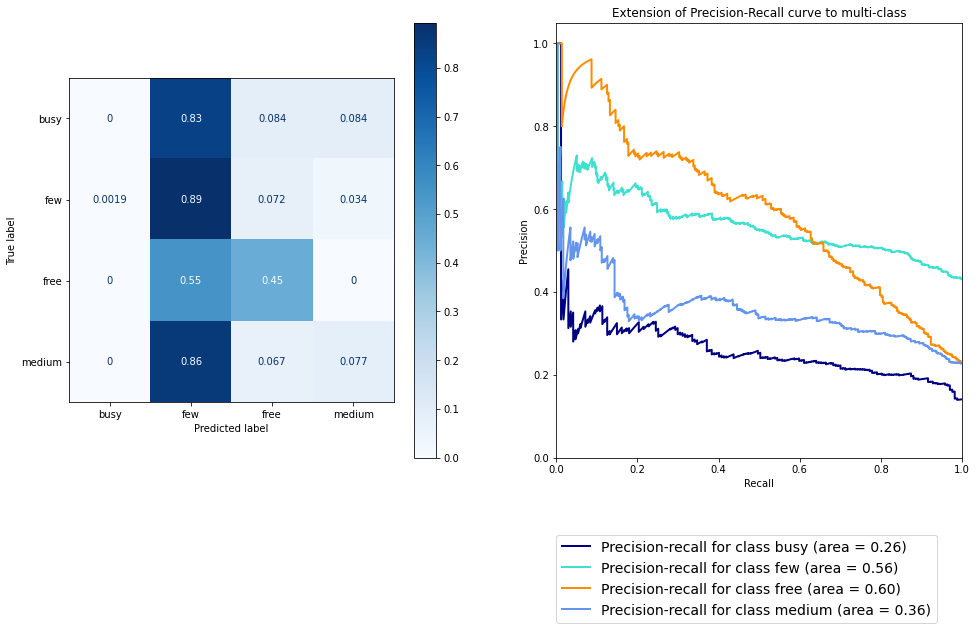

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.47      0.89      0.61       531
           2       0.65      0.45      0.53       287
           3       0.41      0.08      0.13       285

    accuracy                           0.49      1270
   macro avg       0.38      0.36      0.32      1270
weighted avg       0.43      0.49      0.41      1270

training samples from audio:  2000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.2min finished


{'n_estimators': 484, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}
accuracy: 0.49921259842519683
[[0.0239521  0.74251497 0.10778443 0.1257485 ]
 [0.00376648 0.86252354 0.09416196 0.03954802]
 [0.01393728 0.49825784 0.48083624 0.00696864]
 [0.00701754 0.8        0.07368421 0.11929825]]


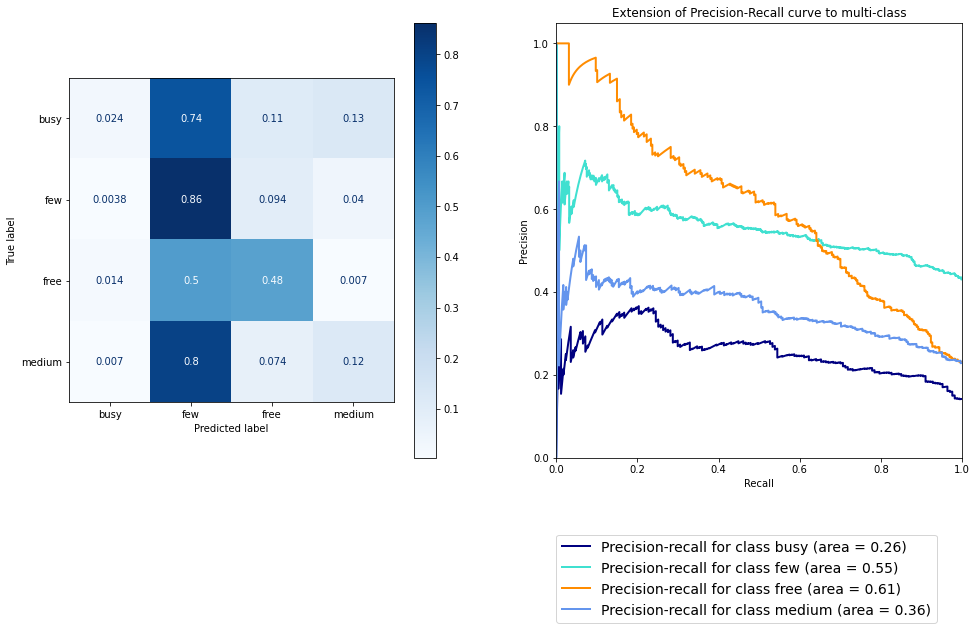

              precision    recall  f1-score   support

           0       0.33      0.02      0.04       167
           1       0.48      0.86      0.62       531
           2       0.61      0.48      0.54       287
           3       0.44      0.12      0.19       285

    accuracy                           0.50      1270
   macro avg       0.46      0.37      0.35      1270
weighted avg       0.48      0.50      0.43      1270

training samples from audio:  3000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.9min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.5118110236220472
[[0.1497006  0.5748503  0.08383234 0.19161677]
 [0.02259887 0.77777778 0.13182674 0.06779661]
 [0.02090592 0.39721254 0.53310105 0.04878049]
 [0.06315789 0.63508772 0.09473684 0.20701754]]


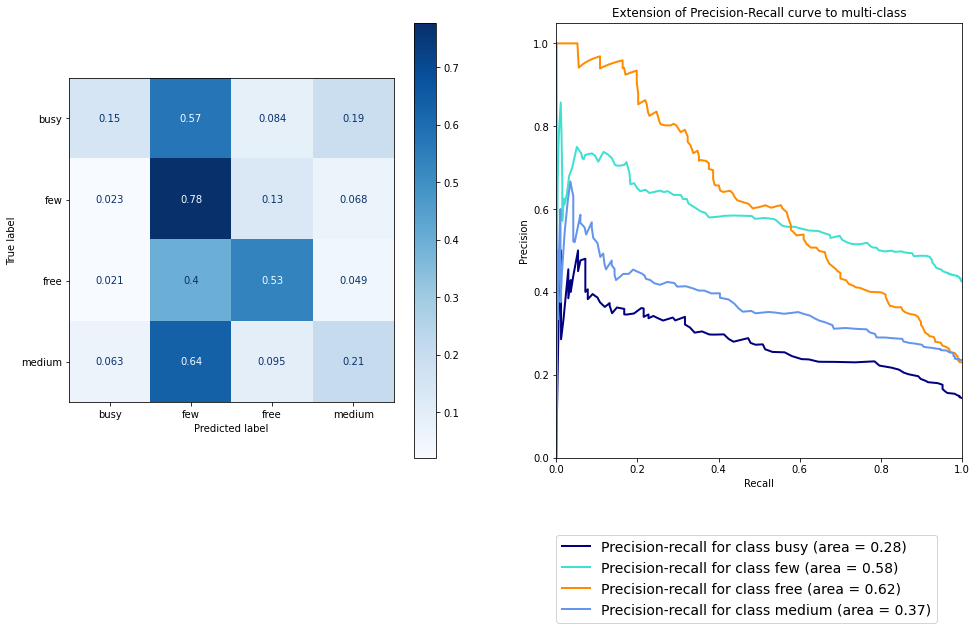

              precision    recall  f1-score   support

           0       0.41      0.15      0.22       167
           1       0.51      0.78      0.62       531
           2       0.58      0.53      0.56       287
           3       0.42      0.21      0.28       285

    accuracy                           0.51      1270
   macro avg       0.48      0.42      0.42      1270
weighted avg       0.49      0.51      0.48      1270

training samples from audio:  4000
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.5min finished


{'n_estimators': 863, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 90}
accuracy: 0.5133858267716536
[[0.14371257 0.59281437 0.05988024 0.20359281]
 [0.01506591 0.77777778 0.1393597  0.06779661]
 [0.02439024 0.38327526 0.55400697 0.03832753]
 [0.06666667 0.64912281 0.0877193  0.19649123]]


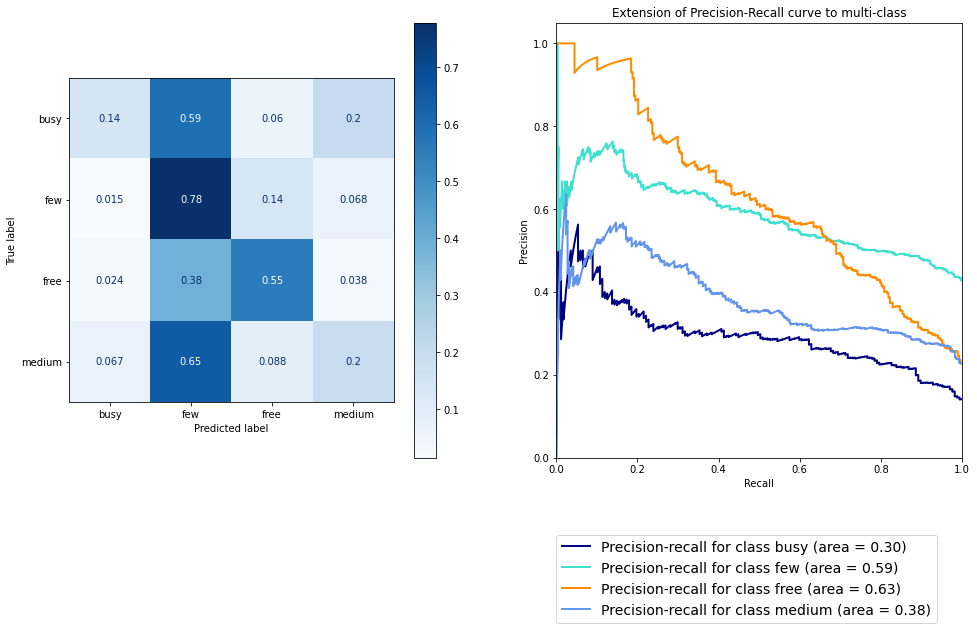

              precision    recall  f1-score   support

           0       0.41      0.14      0.21       167
           1       0.51      0.78      0.62       531
           2       0.59      0.55      0.57       287
           3       0.41      0.20      0.27       285

    accuracy                           0.51      1270
   macro avg       0.48      0.42      0.42      1270
weighted avg       0.49      0.51      0.48      1270

training samples from audio:  5076
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.3min finished


{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100}
accuracy: 0.5141732283464567
[[0.11976048 0.61676647 0.09580838 0.16766467]
 [0.01318267 0.79472693 0.11864407 0.07344633]
 [0.01393728 0.41811847 0.53658537 0.03135889]
 [0.07368421 0.65614035 0.07017544 0.2       ]]


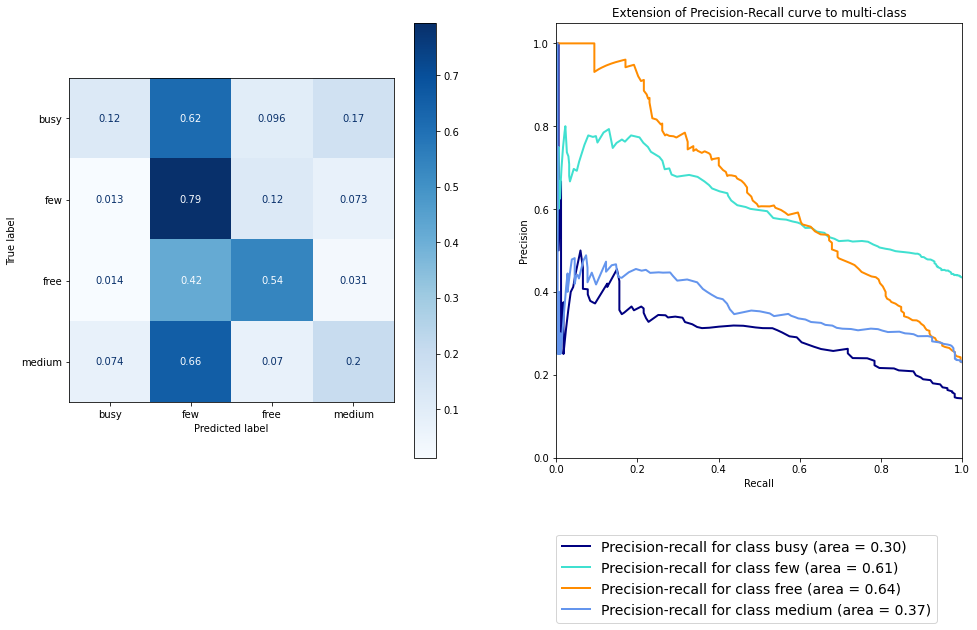

              precision    recall  f1-score   support

           0       0.38      0.12      0.18       167
           1       0.51      0.79      0.62       531
           2       0.61      0.54      0.57       287
           3       0.43      0.20      0.27       285

    accuracy                           0.51      1270
   macro avg       0.48      0.41      0.41      1270
weighted avg       0.50      0.51      0.47      1270



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

acc_range = {}
acc = {}

for num in numOfSamples:
    print("training samples from audio: ", num)

    if num > 0:
        X_combine_train = np.concatenate((X_train[:num, :], features1), axis=0)
        y_combine_train = np.concatenate((y_train[:num],labels["total_encoder"]), axis=0)
    else:
        X_combine_train = features1
        y_combine_train = labels["total_encoder"]

    random_forest_clf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_combine_train, y_combine_train)
    print(rf_random.best_params_)
    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test, labelencoder.classes_)
    acc[num] = random_accuracy
    acc_range[num] = rf_random.cv_results_

In [21]:
print(acc_range)

{0: {'mean_fit_time': array([52.55917056, 26.19993496, 11.64877264, 43.74180396, 18.5220832 ,
        8.91666118, 23.26690873, 35.0345002 ,  6.10700051, 52.43496648]), 'std_fit_time': array([0.95325217, 0.39090722, 0.04021212, 0.67079234, 0.11544859,
       0.14323872, 0.35467097, 0.52034571, 0.08539925, 0.79389427]), 'mean_score_time': array([0.54013999, 0.26804288, 0.13039955, 0.44893424, 0.2075038 ,
       0.09201129, 0.23830541, 0.36057536, 0.06383371, 0.53905543]), 'std_score_time': array([0.00824517, 0.00333543, 0.00242027, 0.00727967, 0.00289527,
       0.00091417, 0.0035579 , 0.00410985, 0.00098129, 0.0093807 ]), 'param_n_estimators': masked_array(data=[1715, 863, 484, 1431, 768, 294, 768, 1147, 200, 1715],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[2, 5, 5, 2, 5, 5, 5, 2, 2, 2],
             mask=[False, False, False,

In [22]:
print(acc)

{0: 0.41811023622047244, 100: 0.4401574803149606, 200: 0.4377952755905512, 500: 0.4763779527559055, 1000: 0.4874015748031496, 1500: 0.49291338582677163, 2000: 0.49921259842519683, 3000: 0.5118110236220472, 4000: 0.5133858267716536, 5076: 0.5141732283464567}
